# Norwegian Postcodes: Latitude-Longitude from Easting-Northing

To plot the Norwegian postcodes, or in fact use them effectively we will need to convert them from the Easting and Northing - the format that they are given in, to a Latitude and Longitude format that we usually see geographical points described in.

The first task is to import the libraries and pickled dataframe. 

In [1]:
import pandas as pd
import numpy as np
import pyproj

# make sure that we are plotting inline
%matplotlib inline

In [2]:
df_raw = pd.read_pickle('postnummerpoly.pkl')
df_raw.head()

,postnummer,poststed,kommune,coordinates
0,1339,VØYENENGA,219,"[[[245469.990020313, 6650942.7998409], [245370..."
1,1361,ØSTERÅS,219,"[[[253912.000015147, 6653573.99987799], [25395..."
2,1354,BÆRUMS VERK,219,"[[[248576.47001836, 6654230.96985486], [248488..."
3,1346,GJETTUM,219,"[[[249541.000017632, 6651700.99986], [249317.0..."
4,1362,HOSLE,219,"[[[253912.000015147, 6653573.99987799], [25385..."


## Preprocessing

The business end of this is the coordinates. These aren't in the usual format, latitude and longitude in hours and minutes, but rather in Easting and Northing. You can reading more about this on [Wikipedia](https://en.wikipedia.org/wiki/Easting_and_northing). Effectively they are cartesian coordinates on a map for a point, where the Easting is the x direction, while the Northing is the y direction. We then also need to know a projection, as the Easting and Northing coordinates are commonly measured in meters from the axes of some specified datum. The coordinate system is ["EPSG: 6173"](http://epsg.io/6173) ([additional link](https://register.geonorge.no/epsg-koder/euref89-utm-sone-33-2d-nn54/615598da-c0cb-4efb-83d4-f678be50db67)), and that will be needed by pyproj to do the conversion to latitude and longitude. Further more, the datum we want to convert these to is the World Geodetic System of 1984 (WGS84) - ["EPSG: 4326"](http://epsg.io/4326). 

So lets try this on a test set. My old flat in Porsgrunn had the cost code, 3915, and the approximate location was 59.142115, 9.655644. We should be near there in the test.

Lets extract the coordinates for that location, and make it into a numpy array. We can then take an "average" location of that polygon to get an approximate center.

In [3]:
porsgrunn_code = df_raw.coordinates[df_raw.postnummer == 3915].values[0][0]
porsgunn_poly_en = np.array(porsgrunn_code)
porsgunn_poly_en = np.mean(porsgunn_poly_en, axis=0)

In [4]:
NN54 = pyproj.Proj(init='epsg:6173')
wgs84 = pyproj.Proj(init='epsg:4326')
lon,lat = pyproj.transform(NN54, wgs84, porsgunn_poly_en[0], porsgunn_poly_en[1])
print (lon, lat)

9.658135004628571 59.14114287993272


Close enough. Lets now change them all! Lets try this first on just the array from the cell. Lets put it into a function to apply across the full array. Then test it on the Porsgrunn postcode.

In [5]:
def project_array(poly_cords):
    # get the poly array in the dataframe into a np array
    poly_array = np.array(poly_cords[0])
    
    # set the current projection datum
    NN54 = pyproj.Proj(init='epsg:6173')
    
    # set the new projection datum
    wgs84 = pyproj.Proj(init='epsg:4326')
    
    # extract the 
    fx, fy = pyproj.transform(NN54, wgs84, poly_array[:, 0], poly_array[:, 1])
    
    # combine the x and y
    coords = np.dstack([fx, fy])[0] 
    
    return coords

In [6]:
print(project_array(df_raw.coordinates[df_raw.postnummer == 3915].values[0]))

[[ 9.65433141 59.14669314]
 [ 9.65445646 59.14600537]
 [ 9.65488241 59.14463764]
 [ 9.65405803 59.14296578]
 [ 9.65172866 59.14128578]
 [ 9.64876539 59.14052445]
 [ 9.65100076 59.1398282 ]
 [ 9.65148028 59.13947652]
 [ 9.65058293 59.13927495]
 [ 9.65129354 59.13864269]
 [ 9.6521556  59.13884918]
 [ 9.65187935 59.13906248]
 [ 9.65216896 59.13915237]
 [ 9.65202622 59.13925996]
 [ 9.65255855 59.13944734]
 [ 9.65252628 59.13957415]
 [ 9.65233911 59.13973291]
 [ 9.65226104 59.13971367]
 [ 9.65219195 59.13975563]
 [ 9.65197082 59.13993224]
 [ 9.65254068 59.14016077]
 [ 9.6529285  59.13987576]
 [ 9.65243419 59.13972406]
 [ 9.65258165 59.13957959]
 [ 9.65275899 59.13951276]
 [ 9.65310013 59.13927316]
 [ 9.65328864 59.13934322]
 [ 9.65332346 59.13931091]
 [ 9.65337985 59.1393423 ]
 [ 9.65350656 59.1392543 ]
 [ 9.65381696 59.13940507]
 [ 9.65384732 59.13948867]
 [ 9.65457576 59.14008082]
 [ 9.65601634 59.13976725]
 [ 9.65682434 59.14053536]
 [ 9.65800154 59.14026536]
 [ 9.65824693 59.1398806 ]
 

Looks good. I think this should be fine. Before we spend some time on processing all, lets just quickly test how this might look using Shapely. Is this going the way we want it to?

In [7]:
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

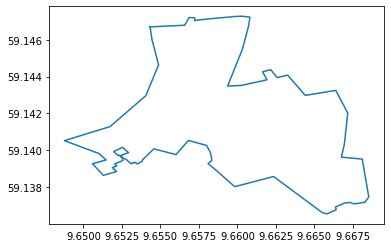

In [8]:
porsgrun_polygon = geometry.Polygon(project_array(df_raw.coordinates[df_raw.postnummer == 3915].values[0]))
x,y = porsgrun_polygon.exterior.xy
plt.plot(x,y)
plt.show()

Okay this is totally fine. Lets apply this the full dataframe. We want to convert the coordinates in Easting and Northing to Lat/Long.

In [9]:
df_raw['latlong'] = df_raw['coordinates'].apply(project_array)
df_raw.head()

,postnummer,poststed,kommune,coordinates,latlong
0,1339,VØYENENGA,219,"[[[245469.990020313, 6650942.7998409], [245370...","[[10.445696317019141, 59.91713244479797], [10...."
1,1361,ØSTERÅS,219,"[[[253912.000015147, 6653573.99987799], [25395...","[[10.593090602999617, 59.945811697526544], [10..."
2,1354,BÆRUMS VERK,219,"[[[248576.47001836, 6654230.96985486], [248488...","[[10.497083866689294, 59.948471950108775], [10..."
3,1346,GJETTUM,219,"[[[249541.000017632, 6651700.99986], [249317.0...","[[10.517359940671644, 59.92641147537095], [10...."
4,1362,HOSLE,219,"[[[253912.000015147, 6653573.99987799], [25385...","[[10.593090602999617, 59.945811697526544], [10..."


Lets pickle this dataframe for use elsewhere. 

In [10]:
df_raw.to_pickle("./postnummerlatlong.pkl")

## Plotting

Lets plot Oslo's. Its just a collection of the polygons, where the Poststed is equal to Oslo. First with just a thin wire frame and then with filled colors.

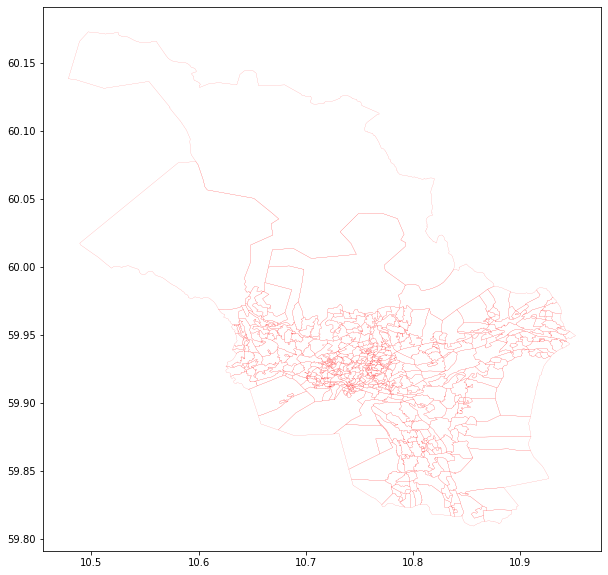

In [11]:
oslo_post_poly = df_raw.latlong[df_raw['poststed']== 'OSLO']
plt.figure(figsize=(10,10))
for i in list(range(len(oslo_post_poly.values))):
    polygon = geometry.Polygon(oslo_post_poly.values[i])
    x,y = polygon.exterior.xy
    plt.plot(x,y, 'r', linewidth=0.1 )
plt.show()

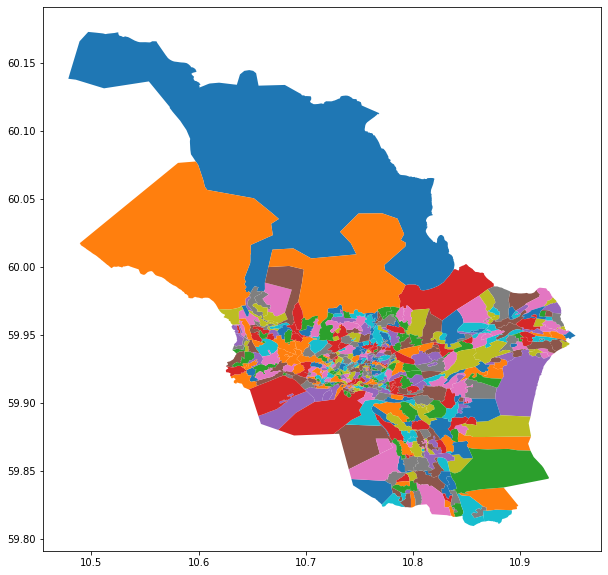

In [12]:
plt.figure(figsize=(10,10))
for i in list(range(len(oslo_post_poly.values))):
    polygon = geometry.Polygon(oslo_post_poly.values[i])
    x,y = polygon.exterior.xy
    plt.fill(x,y, linewidth=0.1 )
plt.show()